In [1]:
import pandas as pd
from pandas.io.gbq import read_gbq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## The general challenge is to look at how extreme weather affects 311 service requests: First we have to define and identify extreme weather. Second we have to look how extreme weather events affect 311 request types and volume. Lastly, can we predict call/complaint volume for extreme weather events such as high/low temperature, snow, rain etc. ?

In [2]:
#let's look at the data! start with weather data: pull for 2010-2017 for the central park station
query = "SELECT DATE(CAST(year AS INT64), CAST(mo AS INT64), CAST(da AS INT64)) as created_date, temp, wdsp, mxpsd, gust, max, min, prcp, sndp, snow_ice_pellets FROM `bigquery-public-data.noaa_gsod.gsod20*` WHERE _TABLE_SUFFIX BETWEEN '10' AND '17' AND stn = '725053' AND wban = '94728'"
weather = read_gbq(query=query, project_id='opendataproject-180502', dialect='standard')

Requesting query... ok.
Query running...
Query done.
Processed: 2.6 Gb

Retrieving results...
Got 1726 rows.

Total time taken 3.9 s.
Finished at 2017-09-23 17:13:03.


pd.set_option("display.max_columns",1001)

In [3]:
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
0,2015-12-25,62.0,0.7,4.1,999.9,72.0,57.0,0.01,999.9,0
1,2017-09-12,69.0,0.8,4.1,999.9,78.1,55.0,0.00,999.9,0
2,2015-09-06,74.1,1.0,4.1,999.9,87.1,64.9,0.00,999.9,0
3,2015-09-16,75.8,1.5,4.1,999.9,88.0,62.1,0.00,999.9,0
4,2013-08-17,72.6,1.6,4.1,999.9,84.0,64.0,0.00,999.9,0


In [7]:
#do some aggregating for simplicty
query = """SELECT DATE(created_date) AS `created_date`, complaint_type, count(unique_key) AS `count_n`
FROM `bigquery-public-data.new_york.311_service_requests`
GROUP BY DATE(created_date), complaint_type"""
dfcounts = read_gbq(query=query, project_id='opendataproject-180502', dialect='standard')

Requesting query... ok.
Query running...
Query done.
Processed: 517.8 Mb

Retrieving results...
  Got page: 1; 28% done. Elapsed 14.51 s.
  Got page: 2; 55% done. Elapsed 18.95 s.
  Got page: 3; 83% done. Elapsed 24.2 s.
  Got page: 4; 100% done. Elapsed 27.66 s.
Got 362184 rows.

Total time taken 29.75 s.
Finished at 2017-09-23 17:27:05.


In [8]:
dfcounts.head()

,created_date,complaint_type,count_n
0,2010-08-06,Overgrown Tree/Branches,61
1,2010-04-01,Traffic/Illegal Parking,61
2,2017-02-17,Benefit Card Replacement,61
3,2016-11-04,Benefit Card Replacement,61
4,2015-02-13,Benefit Card Replacement,61


In [10]:
dfcounts.sort_values(['created_date'], ascending = 0).head()

,created_date,complaint_type,count_n
99176,2017-09-22,Illegal Parking,21
289674,2017-09-22,School Maintenance,1
295959,2017-09-22,Street Sign - Damaged,1
194626,2017-09-22,Rodent,5
159377,2017-09-22,Noise - Street/Sidewalk,58


In [11]:
#look at total counts per day over time relative to temperature
query = """SELECT DATE(created_date) AS `created_date`, count(unique_key) AS count_n
            FROM `bigquery-public-data.new_york.311_service_requests`
           GROUP BY DATE(created_date)"""
dfdaycounts = read_gbq(query=query, project_id='opendataproject-180502', dialect='standard')

Requesting query... ok.
Query running...
Query done.
Processed: 245.3 Mb

Retrieving results...
Got 2822 rows.

Total time taken 3.75 s.
Finished at 2017-09-23 17:33:27.


In [12]:
dfdaycounts.head()

,created_date,count_n
0,2011-11-20,3072
1,2011-10-01,3072
2,2014-03-02,4096
3,2014-07-27,4096
4,2012-07-20,4608


In [14]:
dfdaycounts['created_date'] = pd.to_datetime(dfdaycounts['created_date'], errors = 'coerce')

In [16]:
dfdaycounts = dfdaycounts.sort_values(['created_date'])

(array([ 733773.,  734138.,  734503.,  734869.,  735234.,  735599.,
         735964.,  736330.]), <a list of 8 Text xticklabel objects>)

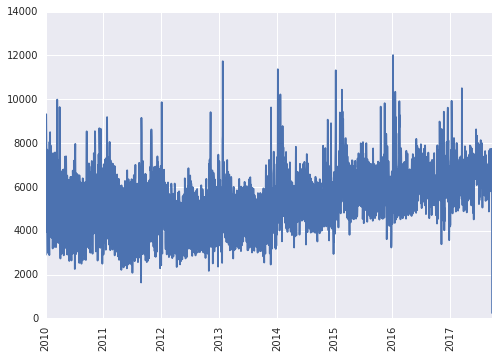

In [22]:
plt.plot(dfdaycounts['created_date'], dfdaycounts['count_n'])
plt.xticks(rotation='vertical')

In [29]:
weather['created_date'] = pd.to_datetime(weather['created_date'], errors = 'coerce')

In [35]:
weather = weather.sort_values(by='created_date')
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
980,2013-01-01,37.8,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0
1105,2013-01-02,27.1,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0
600,2013-01-03,28.4,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0
1479,2013-01-04,33.4,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0
1412,2013-01-05,36.1,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0


(array([ 734959.,  735142.,  735324.,  735507.,  735689.,  735872.,
         736055.,  736238.,  736420.]), <a list of 9 Text xticklabel objects>)

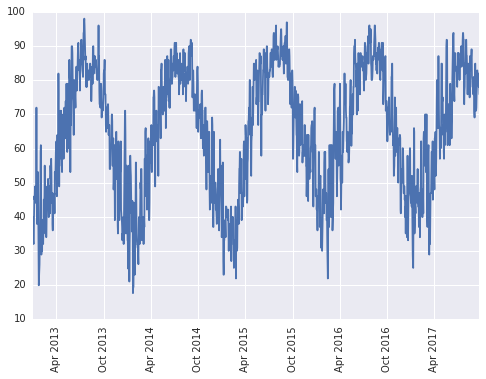

In [37]:
#let's look at temperature across time by max temperature
plt.plot(weather['created_date'], weather['max'])
plt.xticks(rotation='vertical')

In [44]:
weather.head()

,created_date,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,snow_ice_pellets
980,2013-01-01,37.8,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0
1105,2013-01-02,27.1,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0
600,2013-01-03,28.4,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0
1479,2013-01-04,33.4,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0
1412,2013-01-05,36.1,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0


In [45]:
#this weather station started in 2013
dfrecent = dfdaycounts[dfdaycounts['created_date']> pd.to_datetime('2012-12-31')]

In [46]:
dfrecent.head()

,created_date,count_n
33,2013-01-01,3331
18,2013-01-02,7169
982,2013-01-03,6742
2191,2013-01-04,6085
2026,2013-01-05,4024


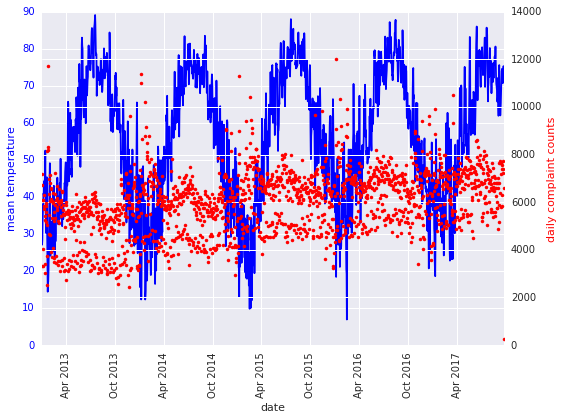

In [68]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(weather['created_date'], weather['temp'], 'b-')
ax1.set_xlabel('date')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('mean temperature', color='b')
ax1.tick_params('y', colors='b')
plt.xticks(rotation='vertical')
ax2 = ax1.twinx()

ax2.plot(dfrecent['created_date'], dfrecent['count_n'], 'r.')
ax2.set_ylabel('daily complaint counts', color='r')
ax2.tick_params('mean daily temperature', colors='r')

fig.tight_layout()
plt.show()
fig.savefig('counts_and_temp.png', dpi = 300)

In [62]:
#looks like the days with the most complaints often fall in the winter. 
#take a closer look at the dates and the weather

In [77]:

dfrecent.sort_values(by = 'count_n', ascending = 0, inplace = True)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [80]:
dfrecent.head(10) #looks like winter days have the highest counts

,created_date,count_n,dayofweek
2641,2016-01-05,12012,1
2377,2013-01-24,11732,3
1174,2014-01-07,11367,1
599,2015-01-08,11318,3
2745,2014-01-08,10998,2
62,2017-03-15,10501,2
2156,2015-02-16,10434,0
1119,2016-01-19,10338,1
2631,2014-01-23,10219,3
2235,2017-01-09,9928,0


In [ ]:
#join in the weather for these days! then look at complaint types
df